# Demonstration: Algorithmic Recourse with Multiple Imputation (ARMIN)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

## 1. Dataset and Classifier

In [2]:
from datasets import Dataset

D = Dataset(dataset='f')
X_tr, X_ts, y_tr, y_ts = D.get_dataset(split=True)

D.get_details()

,Feature,Type,Min,Max,Immutable,Constraint
0,ExternalRiskEstimate,Integer,0.0,94.0,No,Nothing
1,MSinceOldestTradeOpen,Integer,0.0,803.0,No,Nothing
2,MSinceMostRecentTradeOpen,Integer,0.0,383.0,No,Nothing
3,AverageMInFile,Integer,4.0,383.0,No,Nothing
4,NumSatisfactoryTrades,Integer,0.0,79.0,No,Nothing
5,NumTrades60Ever2DerogPubRec,Integer,0.0,19.0,No,Nothing
6,NumTrades90Ever2DerogPubRec,Integer,0.0,19.0,No,Nothing
7,PercentTradesNeverDelq,Integer,0.0,100.0,No,Nothing
8,MSinceMostRecentDelq,Integer,0.0,83.0,No,Nothing
9,MaxDelq2PublicRecLast12M,Integer,0.0,9.0,No,Nothing


In [3]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
clf = clf.fit(X_tr, y_tr)

print('Accuracy: {:.2%}'.format(clf.score(X_ts, y_ts)))
pd.DataFrame([[f, w] for f, w in zip(D.feature_names, clf.coef_[0])], columns=['Feature', 'Coefficient'])

Accuracy: 73.30%


,Feature,Coefficient
0,ExternalRiskEstimate,-0.046510
1,MSinceOldestTradeOpen,-0.000800
2,MSinceMostRecentTradeOpen,0.006588
3,AverageMInFile,-0.007769
4,NumSatisfactoryTrades,-0.033481
5,NumTrades60Ever2DerogPubRec,-0.008642
6,NumTrades90Ever2DerogPubRec,-0.012401
7,PercentTradesNeverDelq,-0.012073
8,MSinceMostRecentDelq,-0.001966
9,MaxDelq2PublicRecLast12M,-0.084958


## 2. Recourse Action before Missing

In [4]:
X_target = X_ts[clf.predict(X_ts)==1]

n = 0
pd.DataFrame([X_target[n], clf.coef_[0]], columns=D.feature_names, index=['Before Missing', 'Coefficient']).T

,Before Missing,Coefficient
ExternalRiskEstimate,63.0,-0.046510
MSinceOldestTradeOpen,179.0,-0.000800
MSinceMostRecentTradeOpen,2.0,0.006588
AverageMInFile,41.0,-0.007769
NumSatisfactoryTrades,16.0,-0.033481
NumTrades60Ever2DerogPubRec,1.0,-0.008642
NumTrades90Ever2DerogPubRec,1.0,-0.012401
PercentTradesNeverDelq,89.0,-0.012073
MSinceMostRecentDelq,10.0,-0.001966
MaxDelq2PublicRecLast12M,4.0,-0.084958


In [5]:
from armin import AlgorithmicRecourseExplainer

ar = AlgorithmicRecourseExplainer(clf, X_tr, y_tr, **D.params, quantile=(0.01, 0.99))
action = ar.extract(X_target[n])
print(ar.getActionObject(action))

* Action (RiskPerformance: Bad -> Good):
	* ExternalRiskEstimate: 63 -> 70 (+7)
	* AverageMInFile: 41 -> 50 (+9)
	* MaxDelq2PublicRecLast12M: 4 -> 5 (+1)
	* NumInqLast6M: 2 -> 0 (-2)
* Scores: 
	* feasible: True
	* valid: True
	* cost: 2.39526609
	* probability: {'Good': 0.5018711406022998, 'Bad': 0.49812885939770024}
	* time: 0.02170610



## 3. Recourse Action after Missing

In [6]:
from armin.missing_helper import MissingGenerator

mg = MissingGenerator(feature_types=D.feature_types, feature_categories=D.feature_categories)
X_missing = mg.mask_instances(X_target, n_missing=1)

pd.DataFrame([X_target[n], X_missing[n], clf.coef_[0]], columns=D.feature_names, index=['Before Missing', 'After Missing', 'Coefficient']).T

,Before Missing,After Missing,Coefficient
ExternalRiskEstimate,63.0,63.0,-0.046510
MSinceOldestTradeOpen,179.0,179.0,-0.000800
MSinceMostRecentTradeOpen,2.0,2.0,0.006588
AverageMInFile,41.0,41.0,-0.007769
NumSatisfactoryTrades,16.0,16.0,-0.033481
NumTrades60Ever2DerogPubRec,1.0,1.0,-0.008642
NumTrades90Ever2DerogPubRec,1.0,1.0,-0.012401
PercentTradesNeverDelq,89.0,89.0,-0.012073
MSinceMostRecentDelq,10.0,10.0,-0.001966
MaxDelq2PublicRecLast12M,4.0,4.0,-0.084958


### [Baseline 1] Algorithmic Recourse with Single Imputation

In [7]:
from armin.missing_helper import SingleImputer

si = SingleImputer(imputer_type='mean', feature_types=D.feature_types, feature_categories=D.feature_categories)
si = si.fit(X_tr)

In [8]:
from armin.baselines import ImputationAlgorithmicRecourseExplainer

iar = ImputationAlgorithmicRecourseExplainer(clf, si, X_tr, y_tr, **D.params, quantile=(0.01, 0.99))
action = iar.extract(X_missing[n])
action = iar.updateActionDicts(X_target[n], action)
print(iar.getActionObject(action))

* Action (RiskPerformance: Bad -> Bad):
	* ExternalRiskEstimate: 63 -> 70 (+7)
	* MaxDelq2PublicRecLast12M: 4 -> 5 (+1)
	* MaxDelqEver: 6 -> 7 (+1)
	* NumInqLast6M: 2 -> 0 (-2)
* Scores: 
	* feasible: True
	* valid: False
	* cost: 2.32423827
	* probability: {'Good': 0.49395986045553086, 'Bad': 0.5060401395444691}
	* time: 0.01743913



### [Baseline 2] Robust Algorithmic Recourse

In [9]:
from armin.missing_helper import MultipleImputer

mi = MultipleImputer(n_sampling=100, imputer_type='mice', feature_types=D.feature_types, feature_categories=D.feature_categories)
mi = mi.fit(X_tr)

In [10]:
from armin.baselines import RobustAlgorithmicRecourseExplainer

rar = RobustAlgorithmicRecourseExplainer(clf, mi, X_tr, y_tr, **D.params, quantile=(0.01, 0.99))
action = rar.extract(X_missing[n])
action = rar.updateActionDicts(X_target[n], action)
print(rar.getActionObject(action))

* Action (RiskPerformance: Bad -> Good):
	* ExternalRiskEstimate: 63 -> 75 (+12)
	* MaxDelq2PublicRecLast12M: 4 -> 5 (+1)
	* NumInqLast6M: 2 -> 0 (-2)
	* NumInqLast6Mexcl7days: 2 -> 3 (+1)
* Scores: 
	* feasible: True
	* valid: True
	* cost: 3.63870999
	* probability: {'Good': 0.6304720391012919, 'Bad': 0.36952796089870804}
	* time: 0.18290162



### [Our Proposal] Algorithmic Recourse with Multiple Imputation (ARMIN)

In [11]:
from armin import ArminExplainer

armin = ArminExplainer(clf, mi, X_tr, y_tr, **D.params, quantile=(0.01, 0.99))
action = armin.extract(X_missing[n])
action = armin.updateActionDicts(X_target[n], action)
print(armin.getActionObject(action))

* Action (RiskPerformance: Bad -> Good):
	* ExternalRiskEstimate: 63 -> 73 (+10)
	* AverageMInFile: 41 -> 53 (+12)
	* MaxDelq2PublicRecLast12M: 4 -> 5 (+1)
	* NumInqLast6M: 2 -> 0 (-2)
* Scores: 
	* feasible: True
	* valid: True
	* cost: 2.74953308
	* probability: {'Good': 0.5424779093446367, 'Bad': 0.4575220906553633}
	* time: 0.09087706



## 4. Confidence Path (Optional)

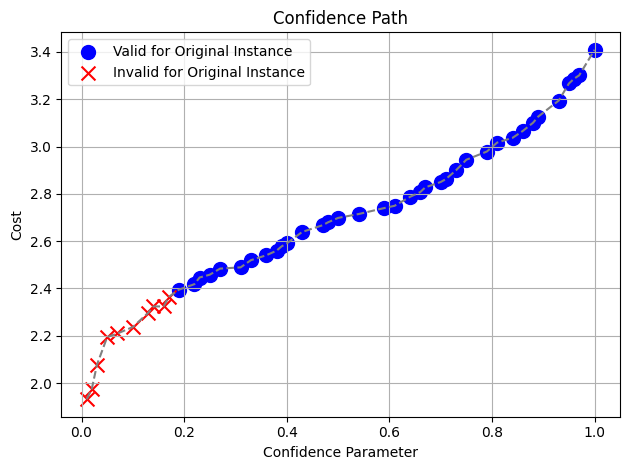

In [12]:
path = armin.confidence_path(X_missing[n])

rhos = []
costs = []
valids = []
for (rho, action) in path:
    action = armin.updateActionDicts(X_target[n], action)
    rhos.append(rho)
    costs.append(action['cost'])
    valids.append(action['valid'])
rhos = np.array(rhos)
costs = np.array(costs)
valids = np.array(valids)

plt.plot(rhos, costs, c='gray', linestyle='dashed')
plt.scatter(rhos[valids], costs[valids], c='blue', label='Valid for Original Instance', s=100, marker='o')
plt.scatter(rhos[~valids], costs[~valids], c='red', label='Invalid for Original Instance', s=100, marker='x')
plt.title('Confidence Path')
plt.xlabel('Confidence Parameter')
plt.ylabel('Cost')
plt.legend()
plt.grid()
plt.tight_layout()

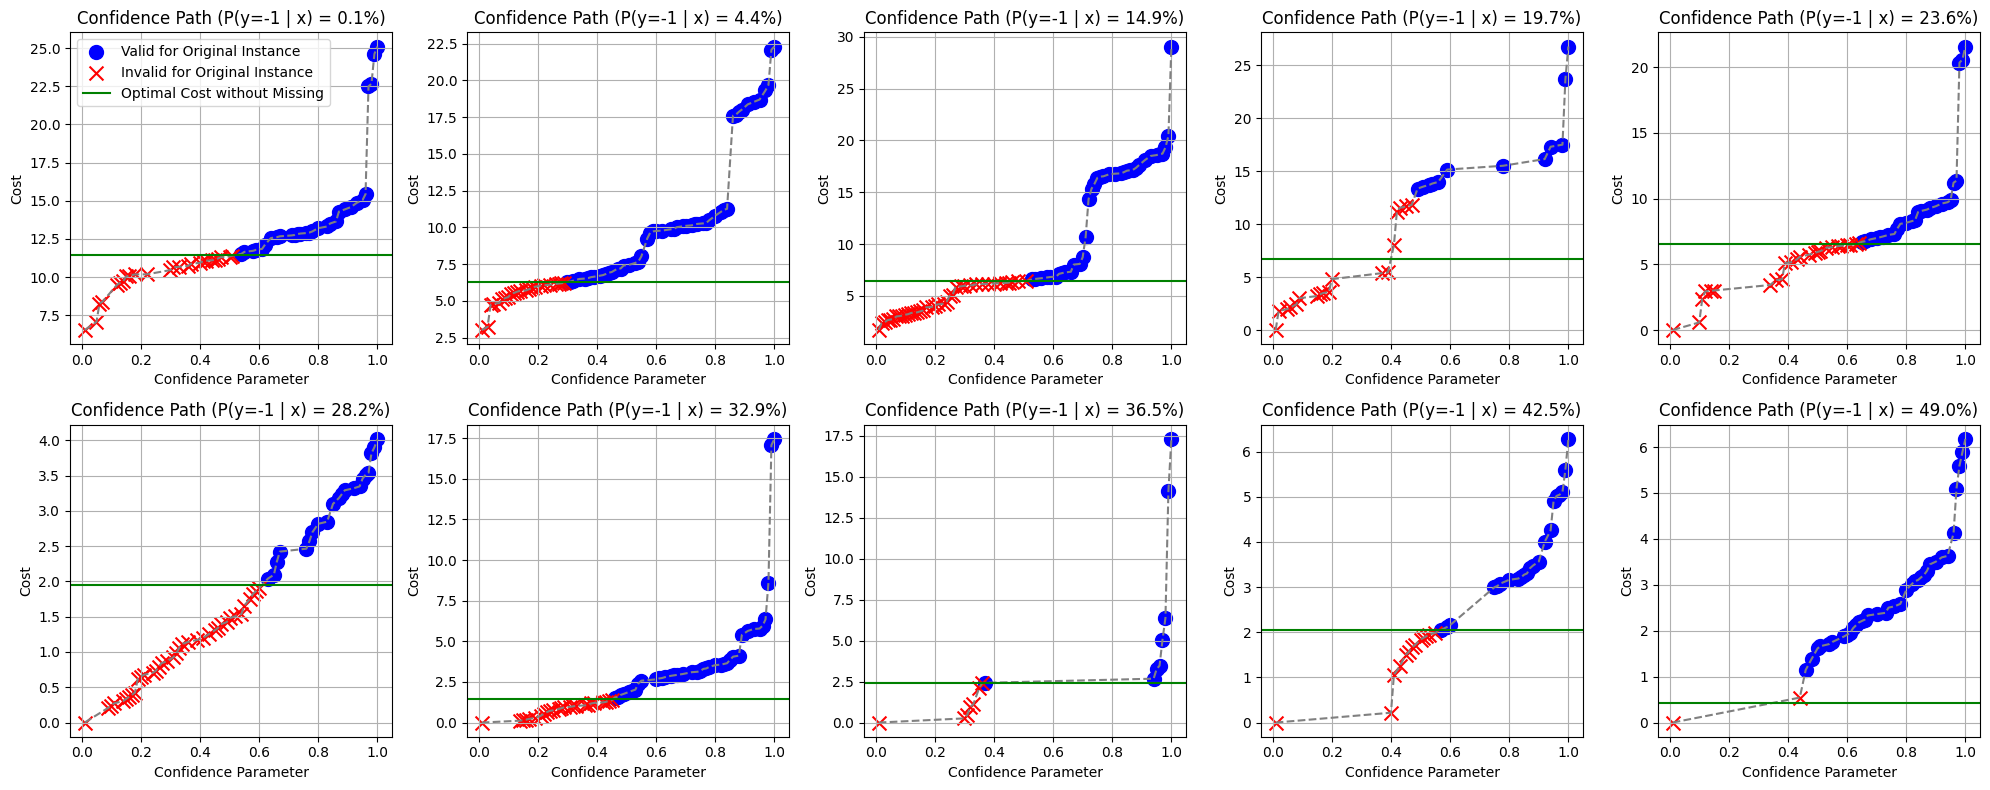

In [13]:
N_plot = 10
df = pd.read_csv('./res/L/path_g_MAR_TLPS.csv')
Ns = df.n.unique()
Ns = Ns[np.linspace(0, len(Ns)-1, N_plot, dtype=int)]

fig = plt.figure(figsize=(20, 0.8 * N_plot))
for i, n in enumerate(Ns):
    df_n = df[df.n == n]
    df_optim = df_n[df_n.method == 'optimal']
    df_armin = df_n[df_n.method == 'armin']

    rhos = df_armin.confidence.values
    costs = df_armin.cost.values
    valids = df_armin.valid.values

    plt.subplot(int(N_plot / 5), 5, i+1)
    plt.plot(rhos, costs, c='gray', linestyle='dashed')
    plt.scatter(rhos[valids], costs[valids], c='blue', label='Valid for Original Instance', s=100, marker='o')
    plt.scatter(rhos[~valids], costs[~valids], c='red', label='Invalid for Original Instance', s=100, marker='x')
    plt.axhline(df_optim.cost.values[0], color='green', label='Optimal Cost without Missing')
    plt.title('Confidence Path (P(y=-1 | x) = {:.1%})'.format(df_armin.y_prob_init.values[0]))
    plt.xlabel('Confidence Parameter')
    plt.ylabel('Cost')
    if i==0: plt.legend()
    plt.grid()
    plt.tight_layout()    

In [14]:
df = pd.read_csv('./res/L/g_MNAR_TLPS.csv')
df.groupby(['method', 'confidence']).mean()

n_missing  feasible     valid       cost  relative_cost  \
method  confidence                                                            
armin   0.4               1.0  1.000000  0.368421   4.156235       0.918259   
        0.5               1.0  1.000000  0.789474   4.838933       1.194997   
        0.6               1.0  1.000000  0.957895   5.416844       1.523515   
        0.7               1.0  1.000000  0.989474   6.197808       1.811524   
        0.8               1.0  1.000000  0.989474   7.347172       2.296910   
knn     1.0               1.0  1.000000  0.842105   4.225050       1.092846   
mean    1.0               1.0  1.000000  0.652632   4.072214       1.040018   
mice    1.0               1.0  1.000000  0.831579   4.237424       1.106991   
optimal 1.0               0.0  1.000000  1.000000   3.941537       1.000000   
robust  1.0               1.0  0.810526  0.810526  16.959787       6.392969   

                        time  probability_target  sign_agreement    y_init  
method  confidence                                                          
armin   0.4         0.032740            0.507565        0.687719  0.842105  
        0.5         0.032287            0.549651        0.684211  0.863158  
        0.6         0.032576            0.585838        0.595614  0.905263  
        0.7         0.033401            0.622311        0.528947  0.884211  
        0.8         0.032224            0.672265        0.506140  0.873684  
knn     1.0         0.034767            0.544901        0.821930  1.000000  
mean    1.0         0.007305            0.534591        0.844737  1.000000  
mice    1.0         0.007530            0.546462        0.799123  0.989474  
optimal 1.0         0.007884            0.521120        1.000000  1.000000  
robust  1.0         0.036951            0.846661        0.446491  0.831579

In [15]:
df = pd.read_csv('./res/L/g_MAR_TLPS.csv')
df.groupby(['method', 'confidence']).mean()

n_missing  feasible     valid       cost  relative_cost  \
method  confidence                                                            
armin   0.4               1.0  1.000000  0.333333   3.347024       0.812042   
        0.5               1.0  1.000000  0.625000   4.072080       1.114281   
        0.6               1.0  1.000000  0.937500   5.014473       1.387081   
        0.7               1.0  1.000000  0.989583   5.449663       1.660826   
        0.8               1.0  1.000000  1.000000   6.447606       2.149194   
knn     1.0               1.0  1.000000  0.531250   3.617622       0.991096   
mean    1.0               1.0  1.000000  0.479167   3.524934       0.967705   
mice    1.0               1.0  1.000000  0.541667   3.704191       1.031812   
optimal 1.0               0.0  1.000000  1.000000   3.656537       1.000000   
robust  1.0               1.0  0.791667  0.791667  16.149485       7.075725   

                        time  probability_target  sign_agreement    y_init  
method  confidence                                                          
armin   0.4         0.032674            0.504204        0.730035  0.822917  
        0.5         0.033421            0.543883        0.779514  0.937500  
        0.6         0.034397            0.576100        0.712674  0.906250  
        0.7         0.033688            0.611551        0.597222  0.916667  
        0.8         0.032730            0.657624        0.536458  0.864583  
knn     1.0         0.034776            0.533956        0.887153  1.000000  
mean    1.0         0.006976            0.525716        0.858507  1.000000  
mice    1.0         0.007327            0.536014        0.867188  1.000000  
optimal 1.0         0.007571            0.536563        1.000000  1.000000  
robust  1.0         0.038763            0.837069        0.464410  0.895833

In [25]:
df = pd.read_csv('./res/M/w_TLPS.csv')
df.groupby(['method', 'confidence']).mean()

,,n_missing,feasible,valid,cost,relative_cost,time,probability_target,sign_agreement,y_init
method,confidence,,,,,,,,,
armin,0.75,2.0,0.986667,0.893333,2.022907,11.522650,49.718015,0.711175,0.503056,0.720000
knn,1.00,2.0,0.966667,0.426667,0.556759,1.064470,0.034125,0.480881,0.638056,0.813333
mean,1.00,2.0,0.960000,0.350000,0.463087,1.215603,0.033118,0.467189,0.532778,0.700000
mice,1.00,2.0,0.960000,0.443333,0.614213,1.546171,0.034679,0.493788,0.651667,0.843333
optimal,1.00,0.0,0.990000,0.990000,0.667620,1.000000,0.040451,0.518981,1.000000,1.000000
robust,1.00,2.0,0.950000,0.943333,4.299920,32.238803,0.551269,0.892207,0.380833,0.703333


In [27]:
df = pd.read_csv('./res/F/w_TLPS.csv')
df.groupby(['n_missing', 'method', 'confidence']).mean()

feasible  valid      cost  relative_cost  \
n_missing method  confidence                                             
0         optimal 1.00             1.0   1.00  0.614043       1.000000   
1         armin   0.75             1.0   0.97  0.966604       2.469105   
          knn     1.00             1.0   0.72  0.595131       1.048643   
          mean    1.00             1.0   0.69  0.592564       0.999363   
          mice    1.00             1.0   0.77  0.624722       1.245858   
          robust  1.00             1.0   1.00  0.780396       2.272394   
2         armin   0.75             1.0   0.93  1.130819       2.236668   
          knn     1.00             1.0   0.53  0.574435       0.943951   
          mean    1.00             1.0   0.52  0.538275       1.076037   
          mice    1.00             1.0   0.56  0.569853       1.044108   
          robust  1.00             1.0   1.00  1.089249       2.448042   
3         armin   0.75             1.0   0.80  1.363429       3.998912   
          knn     1.00             1.0   0.44  0.531669       0.972272   
          mean    1.00             1.0   0.36  0.521844       1.132942   
          mice    1.00             1.0   0.44  0.523204       0.951950   
          robust  1.00             1.0   0.97  1.719572       6.793849   

                                    time  probability_target  sign_agreement  \
n_missing method  confidence                                                   
0         optimal 1.00          0.149860            0.506244        1.000000   
1         armin   0.75        105.024757            0.516819        0.682500   
          knn     1.00          0.141947            0.497642        0.788333   
          mean    1.00          0.129561            0.489896        0.741667   
          mice    1.00          0.137384            0.500956        0.850000   
          robust  1.00          0.629258            0.520662        0.694167   
2         armin   0.75        114.362176            0.518054        0.625000   
          knn     1.00          0.129876            0.490427        0.674167   
          mean    1.00          0.119666            0.481852        0.645000   
          mice    1.00          0.141618            0.488427        0.707500   
          robust  1.00          0.967058            0.530769        0.615000   
3         armin   0.75        107.964296            0.512074        0.490833   
          knn     1.00          0.120546            0.476503        0.636667   
          mean    1.00          0.101582            0.459239        0.556667   
          mice    1.00          0.115558            0.476225        0.659167   
          robust  1.00          1.660248            0.544124        0.473333   

                              y_init  
n_missing method  confidence          
0         optimal 1.00          1.00  
1         armin   0.75          0.95  
          knn     1.00          0.94  
          mean    1.00          0.96  
          mice    1.00          0.99  
          robust  1.00          0.96  
2         armin   0.75          0.87  
          knn     1.00          0.94  
          mean    1.00          0.89  
          mice    1.00          0.97  
          robust  1.00          0.86  
3         armin   0.75          0.81  
          knn     1.00          0.88  
          mean    1.00          0.86  
          mice    1.00          0.89  
          robust  1.00          0.87